In [116]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os
import functools

In [117]:
TE_DATA = np.linspace(8, 512, 64) #ms units

noise_opt = True
SNR_value = 100

T21_center = 40
T22_center = 100

c1 = 0.3
c2 = 0.7

T21_range = np.arange(T21_center-30, T21_center+30+.001, 1)
T22_range = np.arange(T22_center-30, T22_center+30+.001, 1)

mT21, mT22 = np.meshgrid(T21_range, T22_range)

repetitions = 100

lamb_oi = 0.1

RRSS = r'RSS$^{1/2}$'
T21_label = r'$T_{21}$'
T22_label = r'$T_{22}$'
c1_label = r'$c_1$'
c2_label = r'$c_2$'
lamb_lab = r'$\lambda$'


if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

In [118]:
def G_biX(t, con_1, con_2, tau_1, tau_2): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return signal

def J_biX(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

In [119]:
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data


def format_fn(tick_val, tick_pos, labels = ""):
    if int(tick_val) < len(labels):
        return labels[int(tick_val)]
    else:
        return ''

def calculate_RSS(input, func, popt, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_regRSS(input, func, popt, lamb, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    weights = np.array([1,1,1/100,1/100])
    reg = np.sum(lamb**2 *(popt*weights)**2)
    
    return RSS+reg

# Nonregularized Case

In [120]:
true_signal = G_biX(TE_DATA, 0.3, 0.7, T21_center, T22_center)

surface_array = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        temp_param = [0.3, 0.7, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_RSS(TE_DATA, G_biX, temp_param, true_signal)
        surface_array[iT22, iT21] = temp_RSS

trueP_RSS = calculate_RSS(TE_DATA, G_biX, [0.3, 0.7, T21_center, T22_center], true_signal)

In [121]:
minimum_T2_ind = np.zeros([repetitions, 2])
minimum_RSS = np.zeros(repetitions)
freq_array = np.zeros([len(T22_range), len(T21_range)])

for rep in trange(repetitions):

    noisey_sig = add_noise(true_signal, SNR_value)
    temp_surface_array = np.zeros([len(T22_range), len(T21_range)])

    for iT21 in range(len(T21_range)):
        for iT22 in range(len(T22_range)):
            temp_param = [0.3, 0.7, T21_range[iT21], T22_range[iT22]]
            temp_RSS = calculate_RSS(TE_DATA, G_biX, temp_param, noisey_sig)
            temp_surface_array[iT22, iT21] = temp_RSS

    min_indices = np.unravel_index(temp_surface_array.argmin(), temp_surface_array.shape)
    minimum_T2_ind[rep, :] = [T21_range[min_indices[1]], T22_range[min_indices[0]]]

    x_add = min_indices[0]
    y_add = min_indices[1]
    freq_array[x_add, y_add] += 1

    minimum_RSS[rep] = np.min(temp_surface_array)

  2%|▏         | 2/100 [00:00<00:12,  8.07it/s]

100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


Text(0.5, 1.0, 'True Signal for Biexponential Model\n$c_1$, $c_2$, $T_{21}$, $T_{22}$ = 0.3, 0.7, 40, 100')

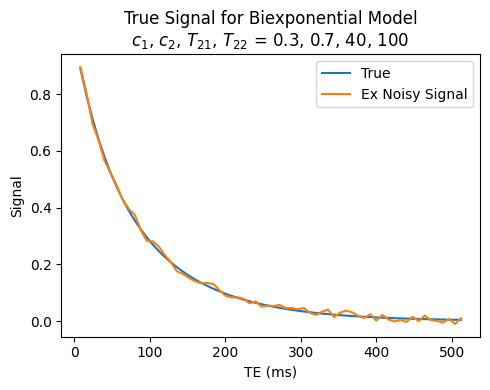

In [122]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(TE_DATA, true_signal, label = "True")
plt.plot(TE_DATA, noisey_sig, label = "Ex Noisy Signal")
plt.xlabel(r'TE (ms)')
plt.ylabel('Signal')
plt.legend()
plt.title(f'True Signal for Biexponential Model\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}')

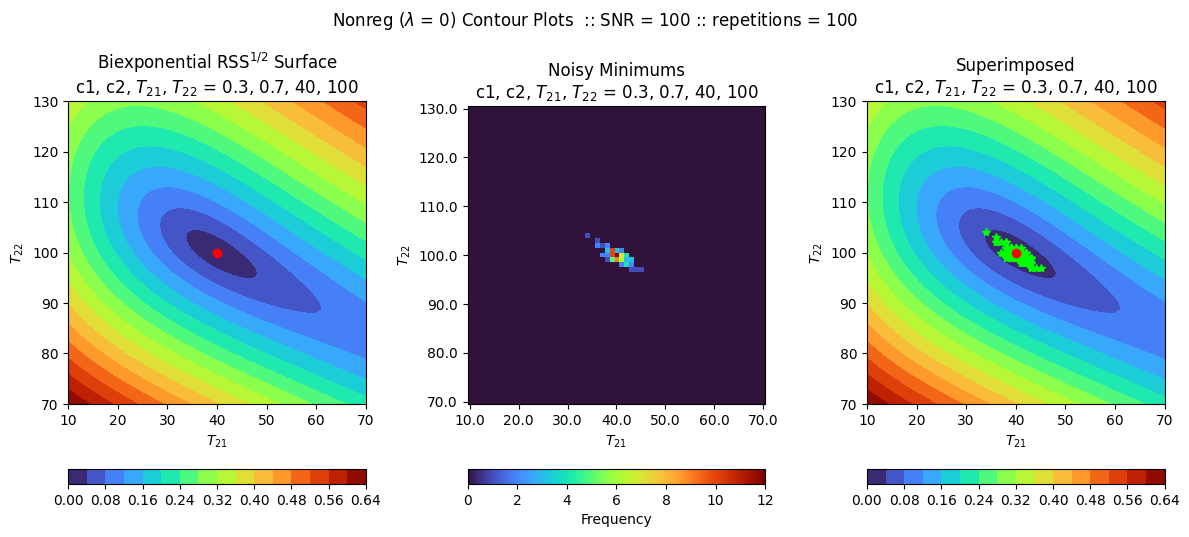

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Nonreg ({lamb_lab} = 0) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].imshow(freq_array, cmap = 'turbo', origin = 'lower')
# ax[1].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax[1].yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
# ax[1].set_ylim([np.min(T22_range), np.max(T22_range)])
# ax[1].set_xlim([np.min(T21_range), np.max(T21_range)])
ax[1].set_title(f'Noisy Minimums' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom', label = 'Frequency')

cp = ax[2].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax[2].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Superimposed' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')

# Regularized Case

In [128]:
true_signal = G_biX(TE_DATA, 0.3, 0.7, T21_center, T22_center)

surface_array_reg = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        temp_param = [0.3, 0.7, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi, true_signal)
        surface_array_reg[iT22, iT21] = temp_RSS

trueP_regRSS = calculate_regRSS(TE_DATA, G_biX, [0.3, 0.7, T21_center, T22_center], lamb_oi, true_signal)

0.017400000000000006


In [125]:
minimum_T2_ind_reg = np.zeros([repetitions, 2])
minimum_RSS_reg = np.zeros(repetitions)
freq_array_reg = np.zeros([len(T22_range), len(T21_range)])

for rep in trange(repetitions):

    noisey_sig = add_noise(true_signal, SNR_value)
    temp_surface_array = np.zeros([len(T22_range), len(T21_range)])

    for iT21 in range(len(T21_range)):
        for iT22 in range(len(T22_range)):
            temp_param = [0.3, 0.7, T21_range[iT21], T22_range[iT22]]
            temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi, noisey_sig)
            temp_surface_array[iT22, iT21] = temp_RSS

    min_indices = np.unravel_index(temp_surface_array.argmin(), temp_surface_array.shape)
    minimum_T2_ind_reg[rep, :] = [T21_range[min_indices[1]], T22_range[min_indices[0]]]

    x_add = min_indices[0]
    y_add = min_indices[1]
    freq_array_reg[x_add, y_add] += 1

    minimum_RSS_reg[rep] = np.min(temp_surface_array)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


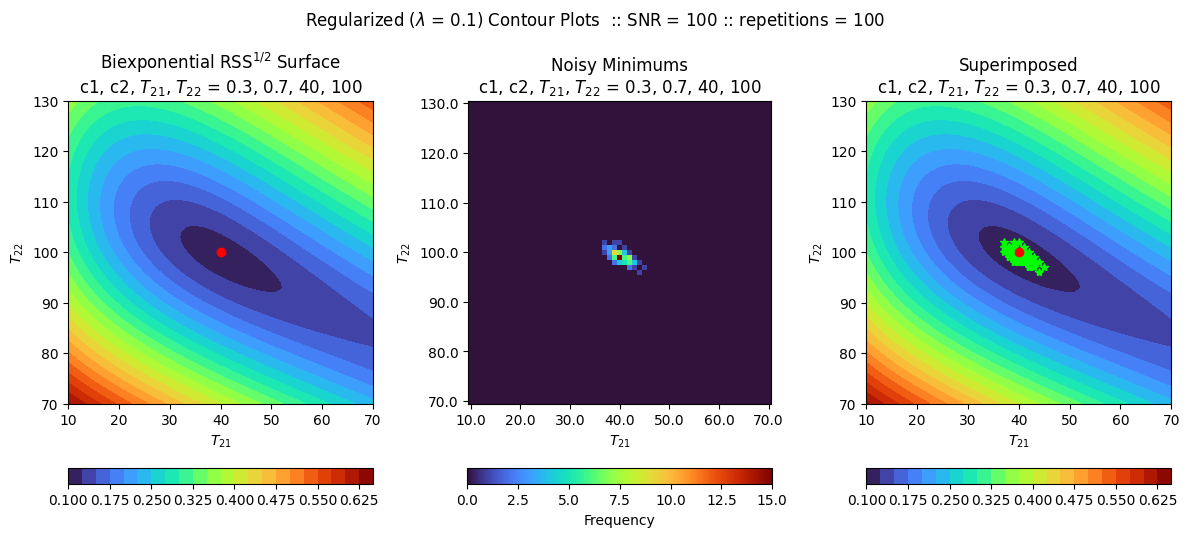

In [126]:


fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Regularized ({lamb_lab} = {lamb_oi}) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array_reg**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS - trueP_regRSS, 20, cmap = 'turbo')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].imshow(freq_array_reg, cmap = 'turbo', origin = 'lower')
# ax[1].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax[1].yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
# ax[1].set_ylim([np.min(T22_range), np.max(T22_range)])
# ax[1].set_xlim([np.min(T21_range), np.max(T21_range)])
ax[1].set_title(f'Noisy Minimums' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom', label = 'Frequency')

cp = ax[2].contourf(mT21, mT22, rootRSS - trueP_regRSS, 20, cmap = 'turbo')
ax[2].plot(minimum_T2_ind_reg[:,0], minimum_T2_ind_reg[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Superimposed' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')

# Difference in Surfaces

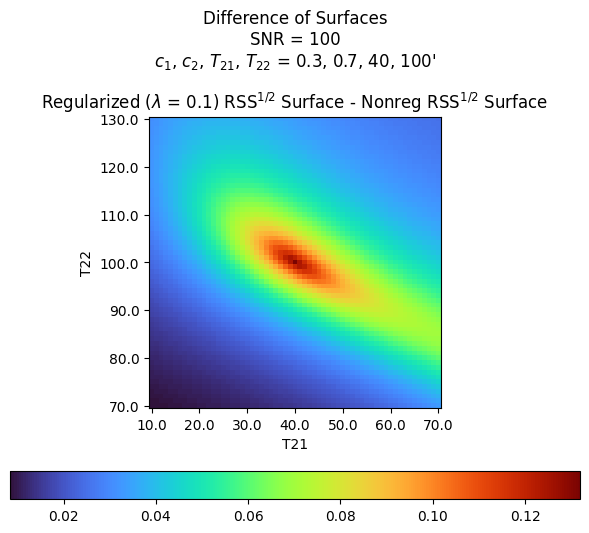

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(6,5.5), tight_layout=True)
fig.suptitle(f"Difference of Surfaces\n{noise_info}\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}'")

diff_vals = surface_array_reg**(1/2) - surface_array**(1/2)

cp = ax.imshow(diff_vals, cmap = 'turbo', origin = "lower")
ax.set_xlabel('T21')
ax.set_ylabel('T22')
ax.xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax.yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
ax.set_title(f'Regularized ({lamb_lab} = {lamb_oi}) {RRSS} Surface - Nonreg {RRSS} Surface')
fig.colorbar(cp, ax = ax, location = 'bottom')